# Dashboard Preparation

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import shap
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from importnb import Notebook

C:\Users\ssmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\ssmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ssmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Test AUC: 0.7400586333909644
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.81       251
           1       0.34      0.64      0.44        53

    accuracy                           0.72       304
   macro avg       0.62      0.69      0.63       304
weighted avg       0.81      0.72      0.75       304

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'learning_rate': 0.04, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 400, 'subsample': 0.7}
Test AUC Score: 0.800796812749004
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       251
           1       0.75      0.45      0.56        53

    accuracy                           0.88       304
   macro avg       0.82      0.71      0.75       304
weighted avg       0.87      0.88      0.87       304

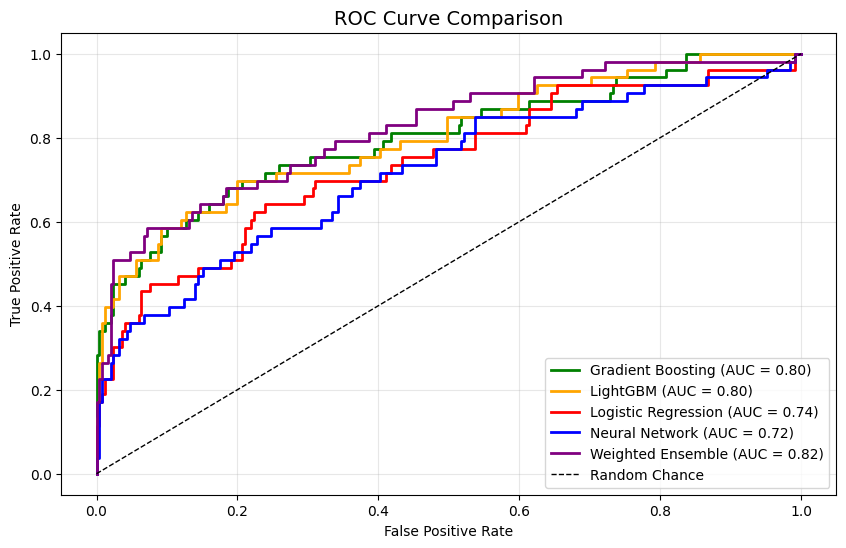

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


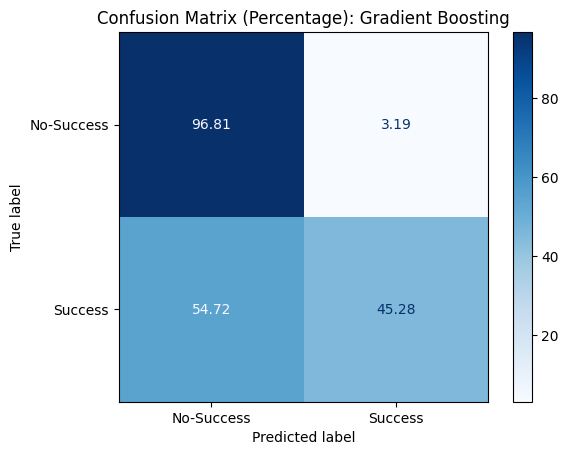

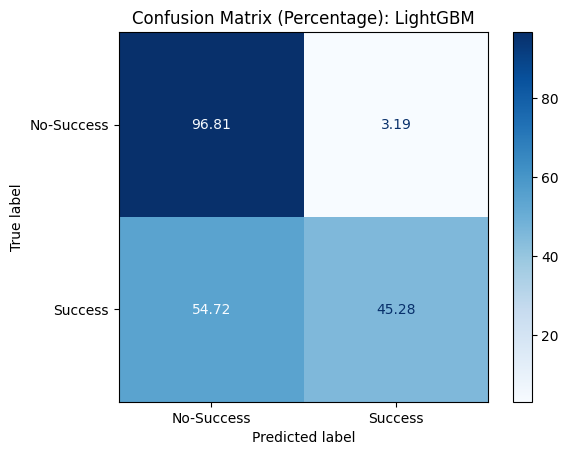

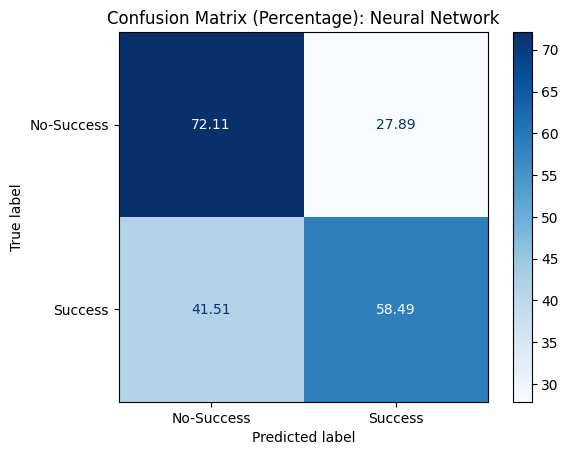

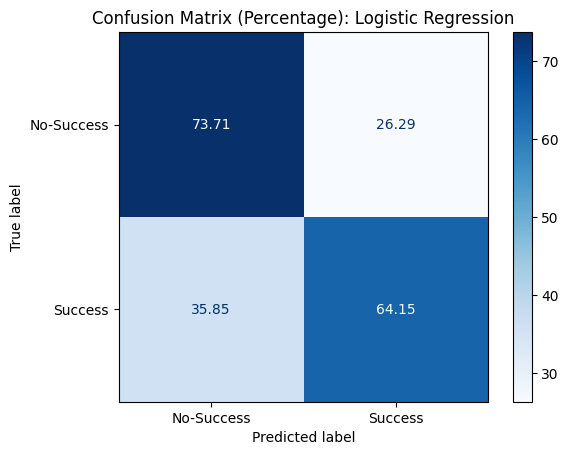

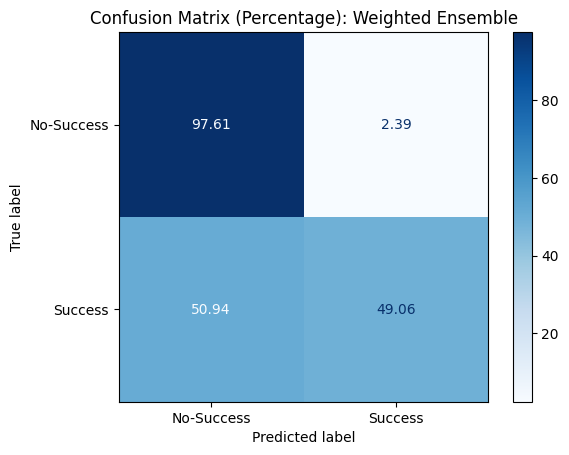

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


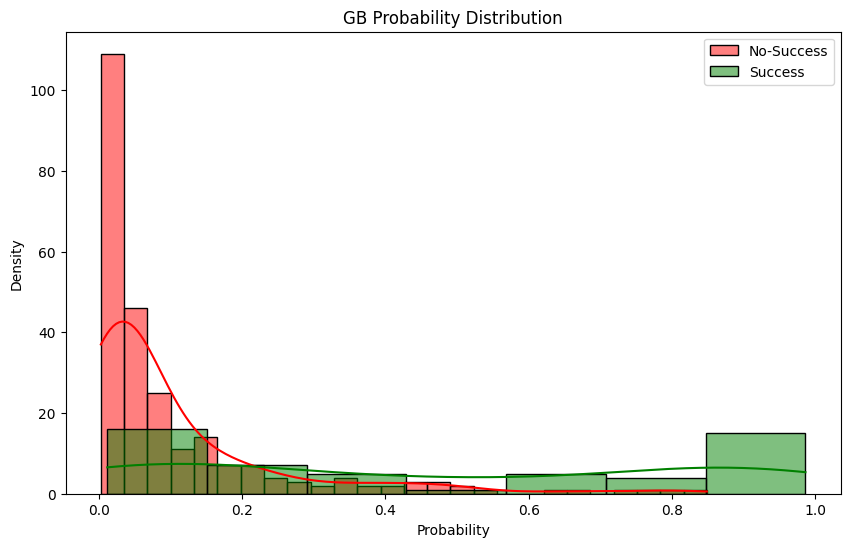

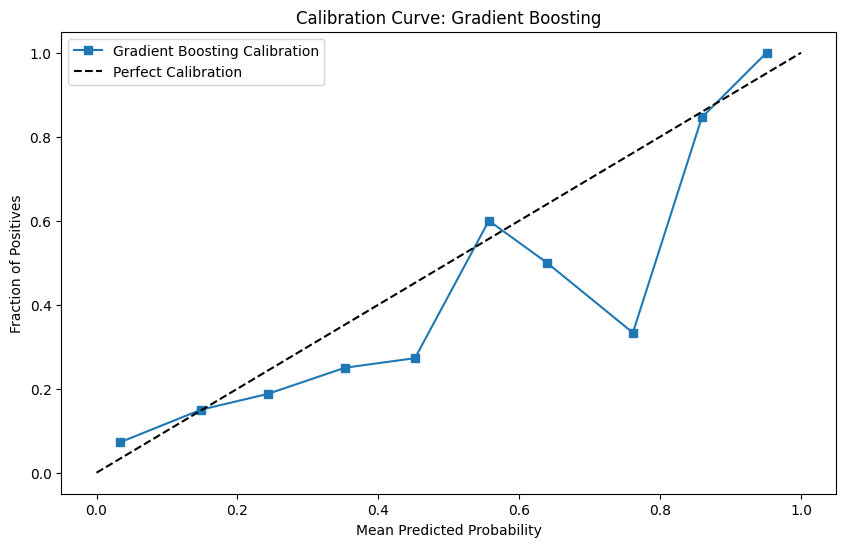

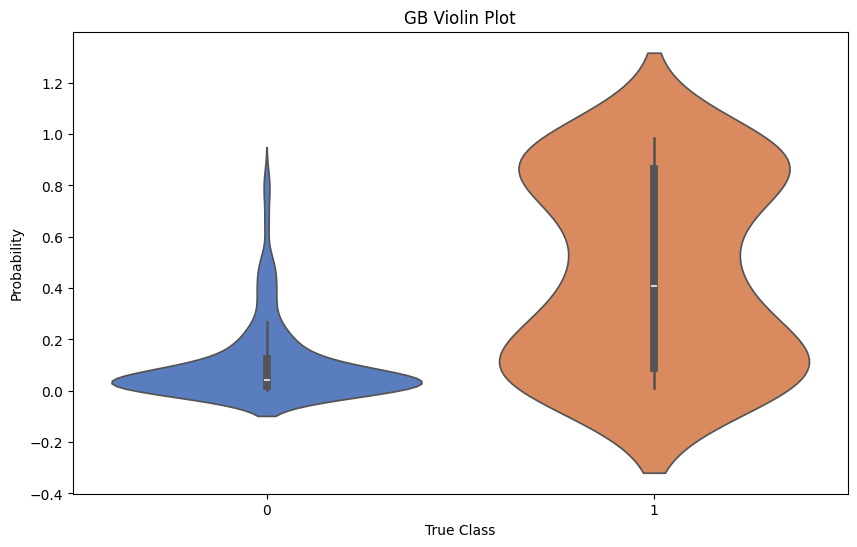

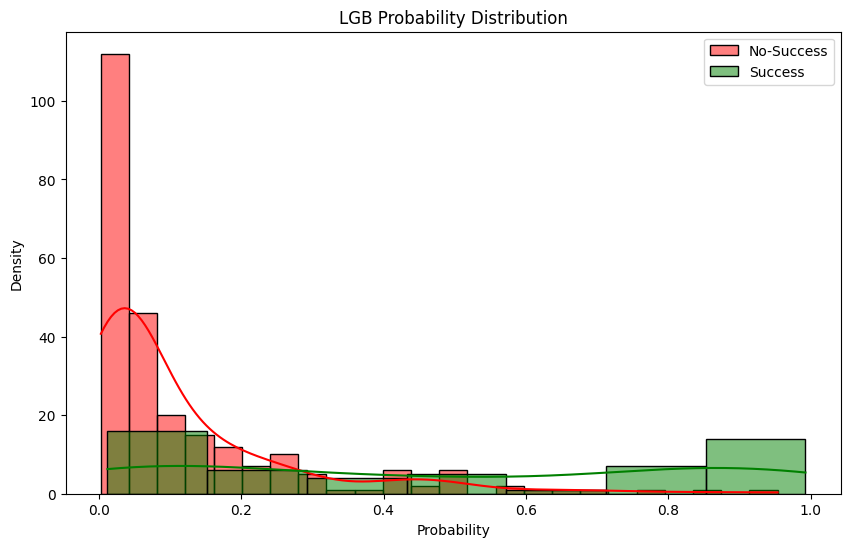

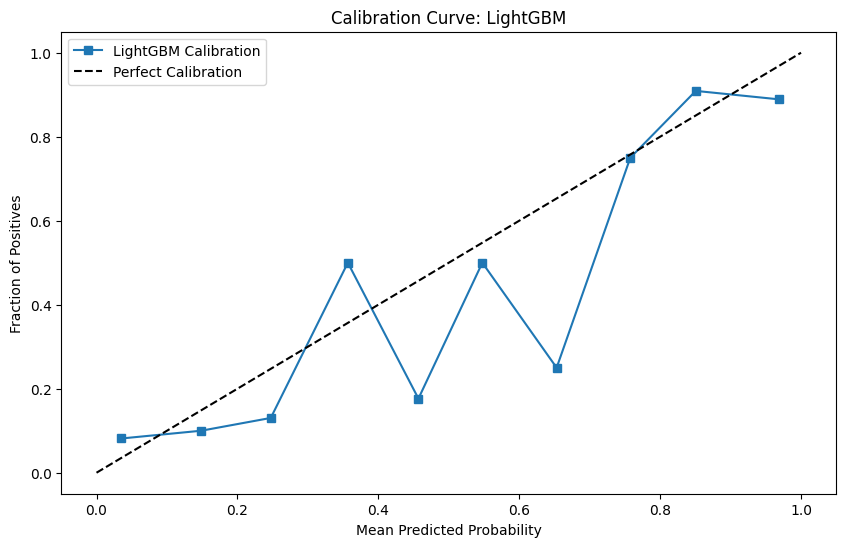

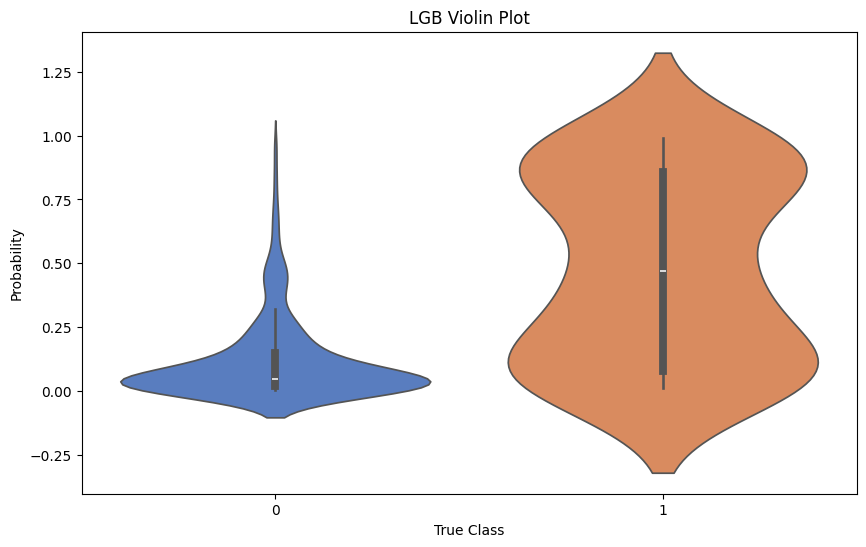

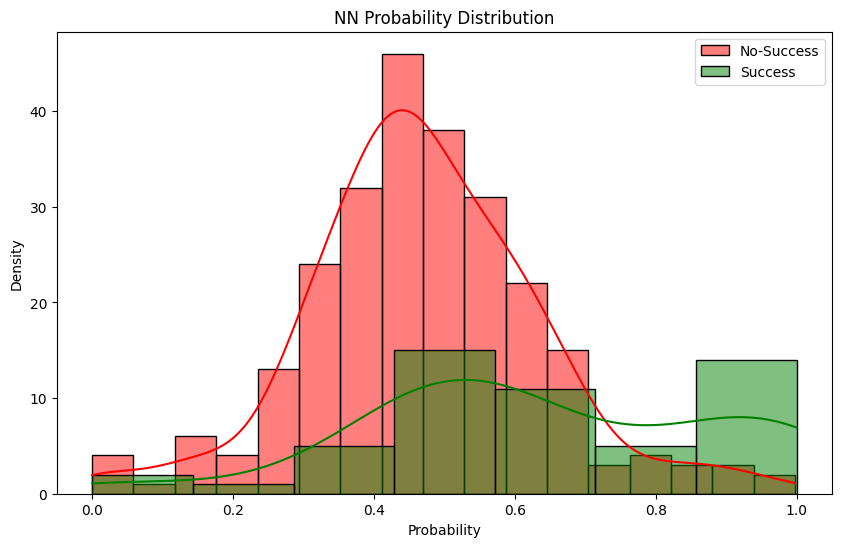

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


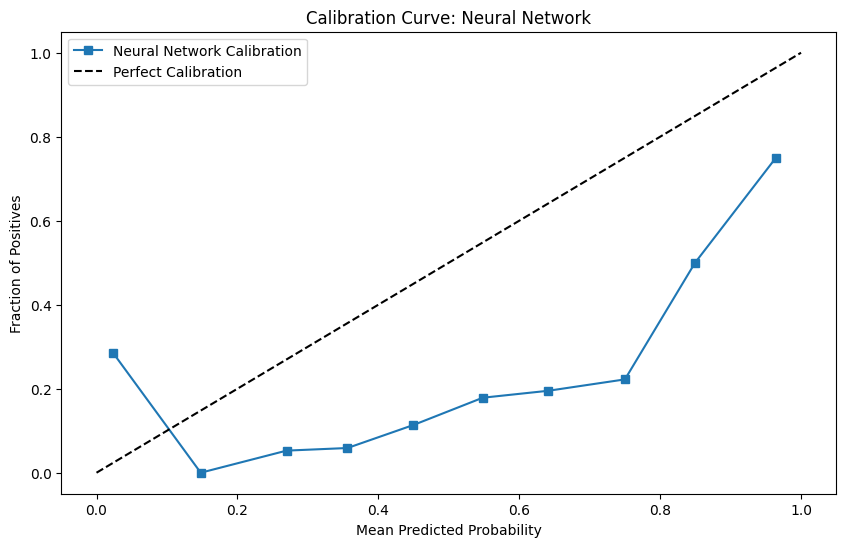

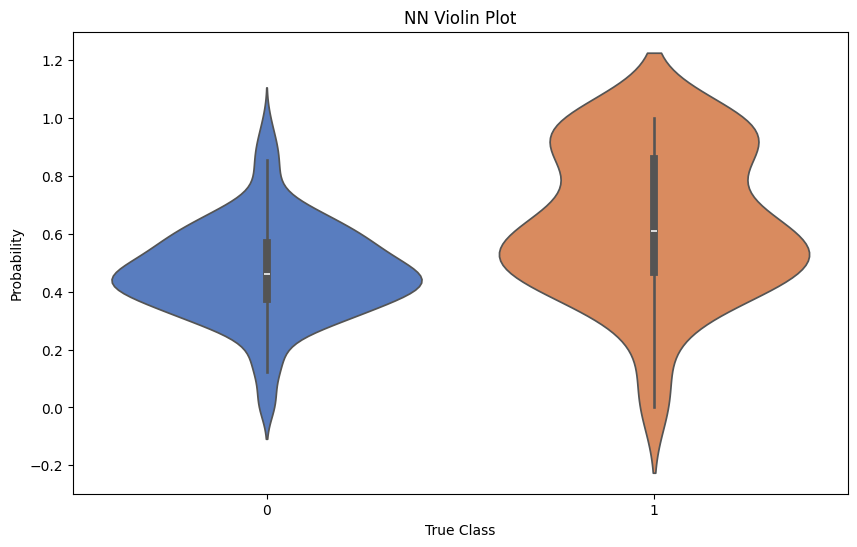

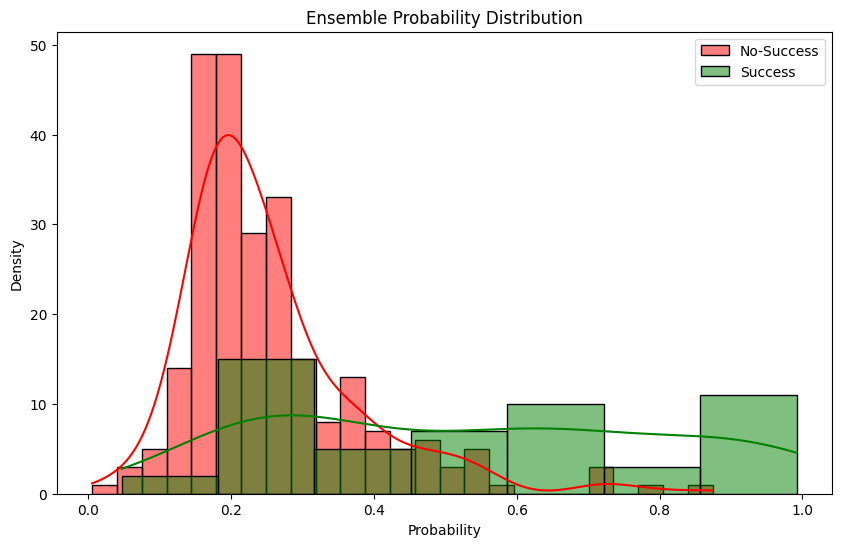

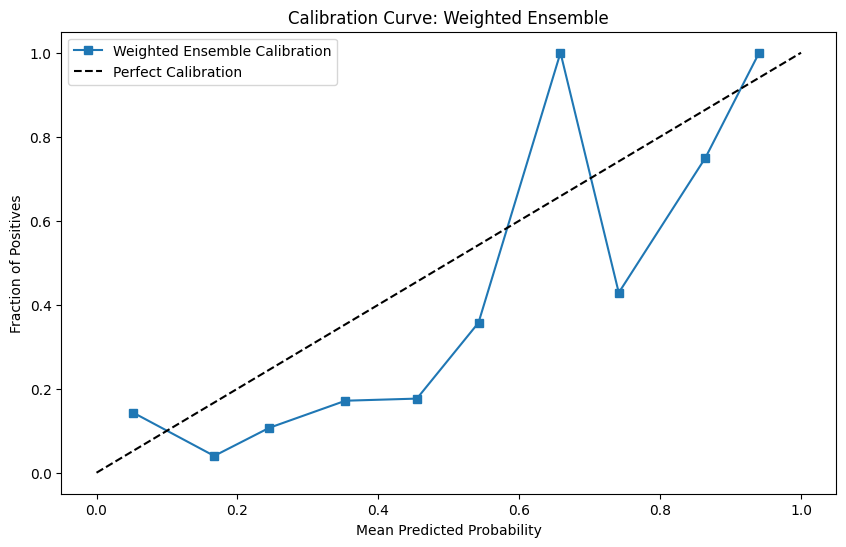

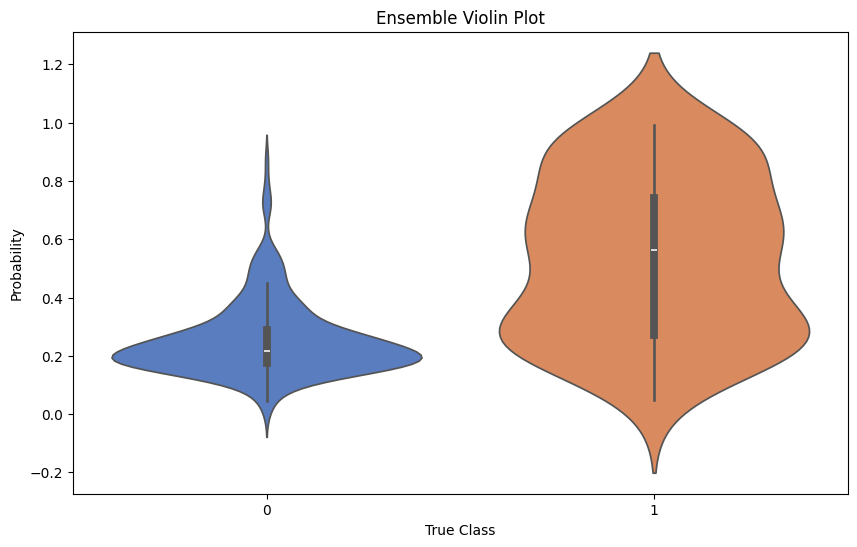

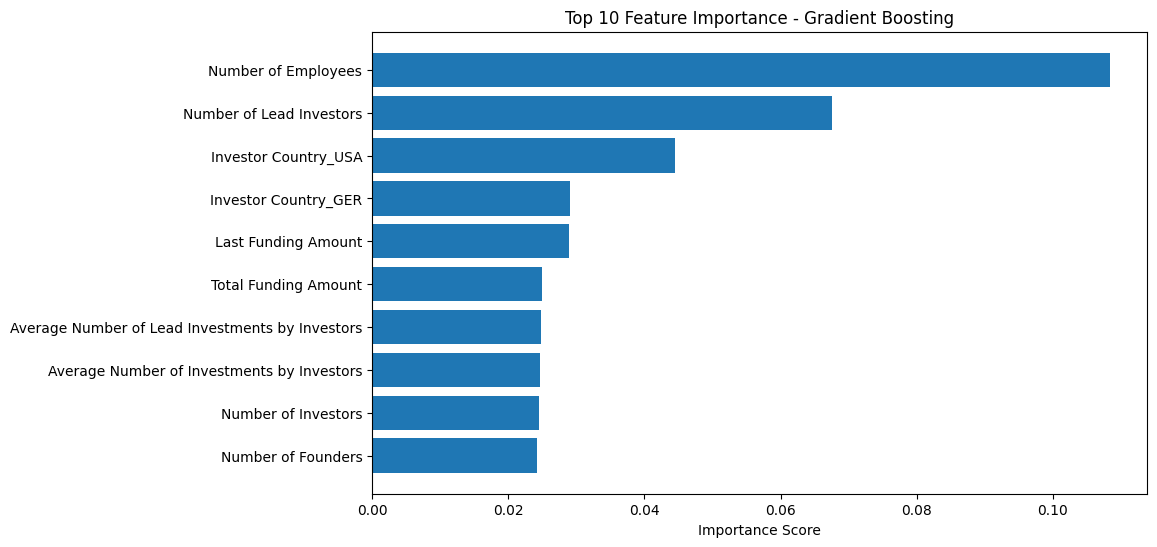

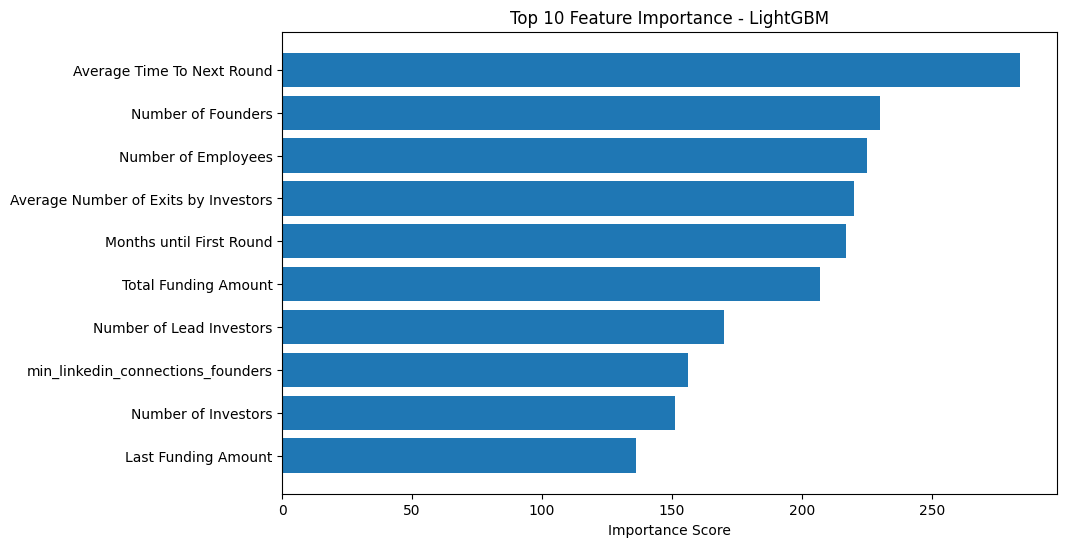

Analyzing Gradient Boosting Model...
Gradient Boosting SHAP Summary Plot:


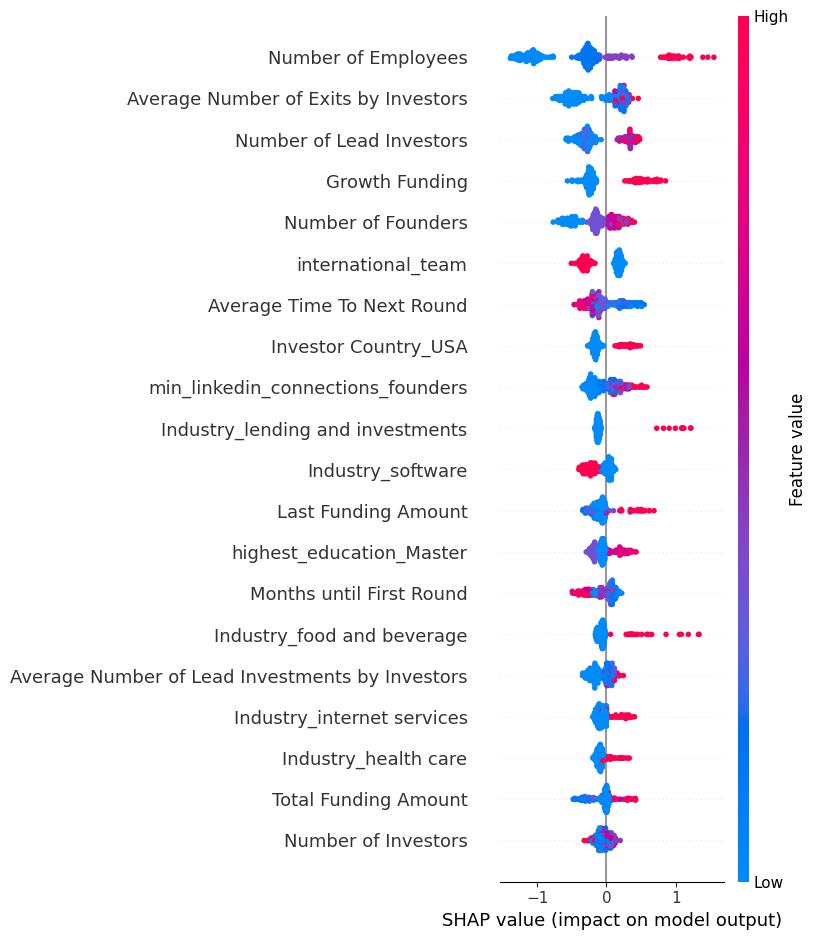

Gradient Boosting SHAP Bar Plot:


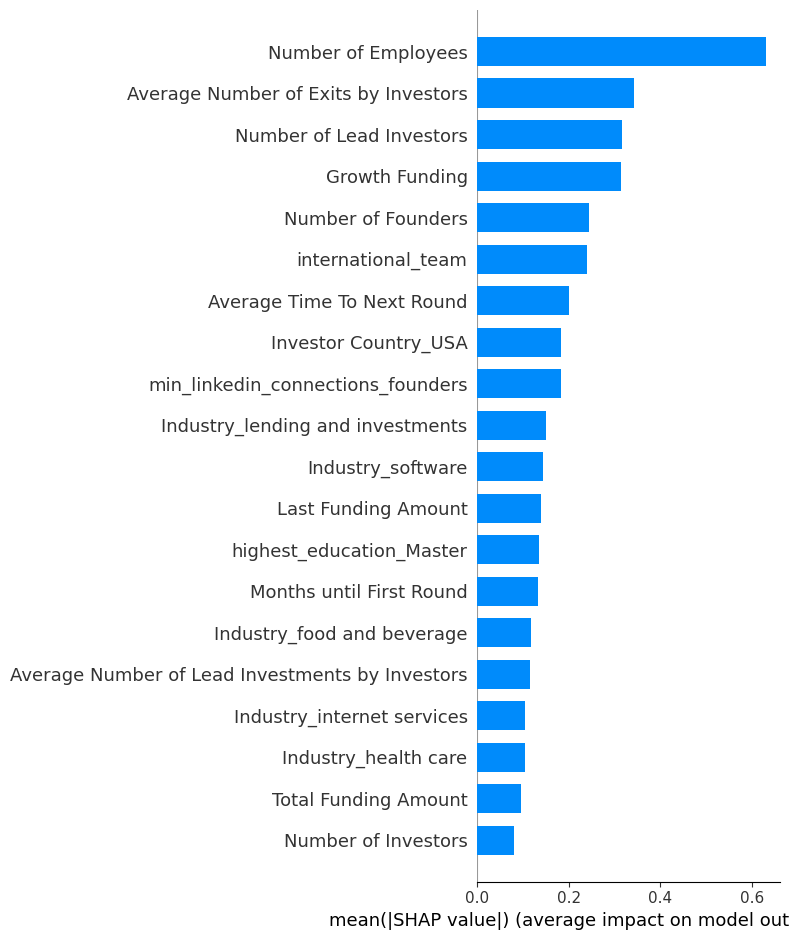

Analyzing LightGBM Model...
LightGBM SHAP Summary Plot:


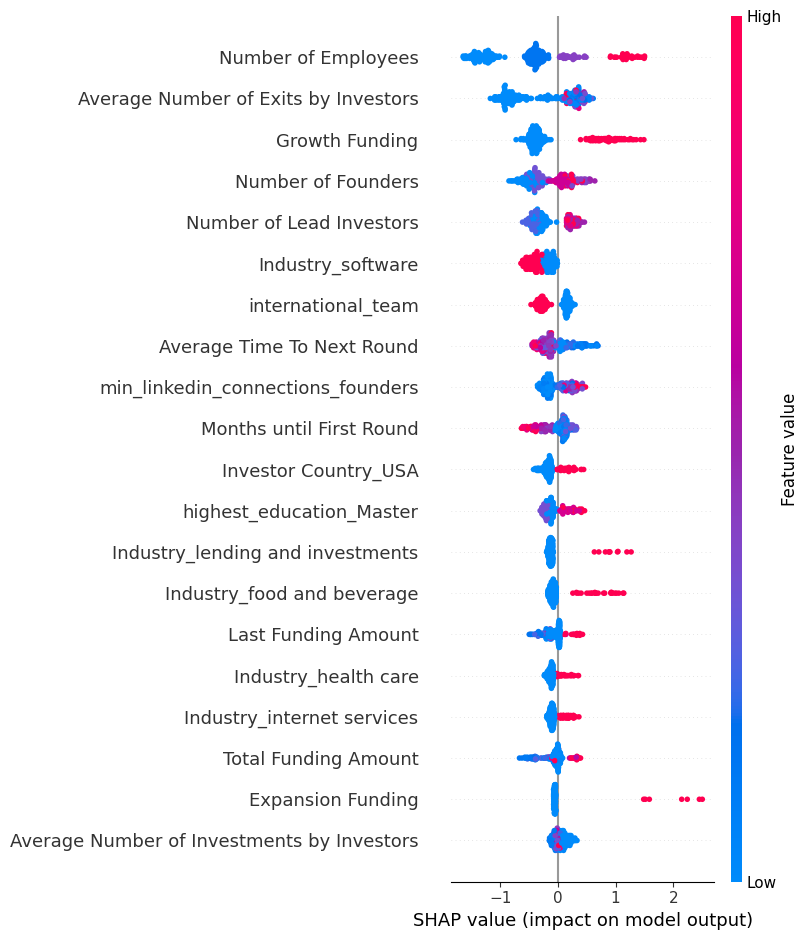

LightGBM SHAP Bar Plot:


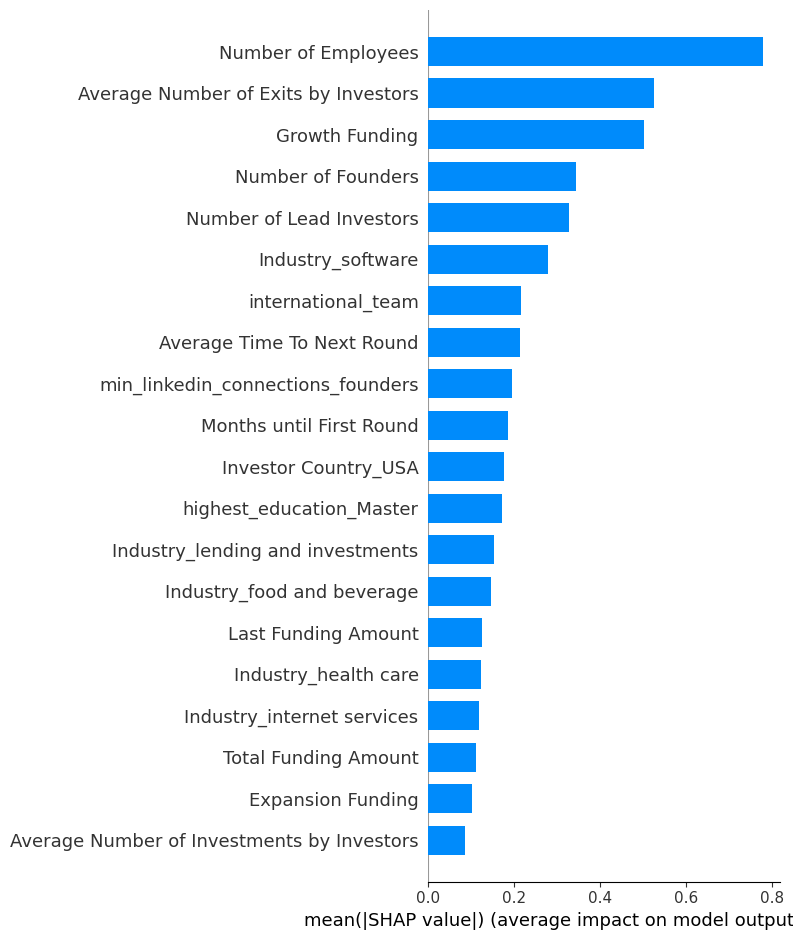

In [2]:
with Notebook():
    from Modelling import (
        data,
        test_results,
        gb_model, gb_test_predictions, gb_test_probabilities, gb_shap_values,
        lgb_model, lgb_test_predictions, lgb_test_probabilities, lgb_shap_values,
        logistic_model, logistic_predictions, logistic_proba,
        nn_model, nn_predictions, nn_test_probabilities,
        ensemble_test_predictions, ensemble_test_probabilities,
        X_test_scaled, X
    )

In [3]:
def prepare_dashboard_data(test_results, feature_names,
                           gb_shap_values, lgb_shap_values,
                           ensemble_test_predictions, ensemble_test_probabilities):
    from sklearn.metrics import confusion_matrix, classification_report
    import numpy as np
    import pandas as pd
    import json

    def prepare_confusion_matrix_section(true_class, predicted_class):
        tn, fp, fn, tp = confusion_matrix(true_class, predicted_class).ravel()
        return {
            "truePositive": int(tp),
            "trueNegative": int(tn),
            "falsePositive": int(fp),
            "falseNegative": int(fn)
        }

    def transform_results(results, prediction_column, probability_column):
        transformed = []
        for _, row in results.iterrows():
            transformed.append({
                "id": row["Observation Index"],
                "actualLabel": "Positive" if row["True Class (Test)"] == 1 else "Negative",
                "predictedLabel": "Positive" if row[prediction_column] == 1 else "Negative",
                "confidence": f"{row[probability_column] * 100:.2f}%",
                "timestamp": pd.Timestamp.now().isoformat()
            })
        return transformed

    def transform_results_ensemble(true_class, predictions, probabilities, observation_ids):
        transformed = []
        for obs_id, actual, pred, prob in zip(observation_ids, true_class, predictions, probabilities):
            transformed.append({
                "id": obs_id,
                "actualLabel": "Positive" if actual == 1 else "Negative",
                "predictedLabel": "Positive" if pred == 1 else "Negative",
                "confidence": f"{prob * 100:.2f}%",
                "timestamp": pd.Timestamp.now().isoformat()
            })
        return transformed

    def format_shap_values(shap_values, feature_names):
        shap_formatted = [
            {"feature": feature, "value": float(shap_value)}
            for feature, shap_value in zip(feature_names, np.abs(shap_values).mean(axis=0))
        ]
        return shap_formatted

    # Format SHAP values für einzelne Modelle
    gb_shap_data = format_shap_values(gb_shap_values, feature_names)
    lgb_shap_data = format_shap_values(lgb_shap_values, feature_names)

    # Gradient Boosting Daten
    gb_data = {
        "name": "Gradient Boosting",
        "stats": {
            "accuracy": (test_results['True Class (Test)'] == test_results['GB Prediction (Test)']).mean(),
            "precision": classification_report(
                test_results['True Class (Test)'],
                test_results['GB Prediction (Test)'],
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                test_results['True Class (Test)'],
                test_results['GB Prediction (Test)'],
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                test_results['True Class (Test)'],
                test_results['GB Prediction (Test)'],
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            test_results['True Class (Test)'],
            test_results['GB Prediction (Test)']
        ),
        "results": transform_results(
            test_results, "GB Prediction (Test)", "GB Probability (Success, Test)"
        ),
        "shapValues": gb_shap_data,
        "paperUrl": "https://arxiv.org/abs/1603.02754"
    }

    # LightGBM Daten
    lgb_data = {
        "name": "LightGBM",
        "stats": {
            "accuracy": (test_results['True Class (Test)'] == test_results['LGB Prediction (Test)']).mean(),
            "precision": classification_report(
                test_results['True Class (Test)'],
                test_results['LGB Prediction (Test)'],
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                test_results['True Class (Test)'],
                test_results['LGB Prediction (Test)'],
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                test_results['True Class (Test)'],
                test_results['LGB Prediction (Test)'],
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            test_results['True Class (Test)'],
            test_results['LGB Prediction (Test)']
        ),
        "results": transform_results(
            test_results, "LGB Prediction (Test)", "LGB Probability (Success, Test)"
        ),
        "shapValues": lgb_shap_data,
        "paperUrl": "https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree"
    }

    # Logistic Regression Daten
    logistic_data = {
        "name": "Logistic Regression",
        "stats": {
            "accuracy": (test_results['True Class (Test)'] == test_results['Logistic Prediction (Test)']).mean(),
            "precision": classification_report(
                test_results['True Class (Test)'],
                test_results['Logistic Prediction (Test)'],
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                test_results['True Class (Test)'],
                test_results['Logistic Prediction (Test)'],
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                test_results['True Class (Test)'],
                test_results['Logistic Prediction (Test)'],
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            test_results['True Class (Test)'],
            test_results['Logistic Prediction (Test)']
        ),
        "results": transform_results(
            test_results, "Logistic Prediction (Test)", "Logistic Probability (Success, Test)"
        ),
        "shapValues": [],
        "paperUrl": "https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html"
    }

    # Neural Network Daten
    nn_data = {
        "name": "Neural Network",
        "stats": {
            "accuracy": (test_results['True Class (Test)'] == test_results['NN Prediction (Test)']).mean(),
            "precision": classification_report(
                test_results['True Class (Test)'],
                test_results['NN Prediction (Test)'],
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                test_results['True Class (Test)'],
                test_results['NN Prediction (Test)'],
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                test_results['True Class (Test)'],
                test_results['NN Prediction (Test)'],
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            test_results['True Class (Test)'],
            test_results['NN Prediction (Test)']
        ),
        "results": transform_results(
            test_results, "NN Prediction (Test)", "NN Probability (Success, Test)"
        ),
        "shapValues": [],
        "paperUrl": "https://arxiv.org/abs/1512.03385"
    }

    # Ensemble Model Daten
    true_classes = test_results['True Class (Test)']
    ensemble_data = {
        "name": "Ensemble Model",
        "stats": {
            "accuracy": (true_classes == ensemble_test_predictions).mean(),
            "precision": classification_report(
                true_classes,
                ensemble_test_predictions,
                output_dict=True
            )['macro avg']['precision'],
            "recall": classification_report(
                true_classes,
                ensemble_test_predictions,
                output_dict=True
            )['macro avg']['recall'],
            "f1Score": classification_report(
                true_classes,
                ensemble_test_predictions,
                output_dict=True
            )['macro avg']['f1-score']
        },
        "confusionMatrix": prepare_confusion_matrix_section(
            true_classes,
            ensemble_test_predictions
        ),
        "results": transform_results_ensemble(
            true_classes,
            ensemble_test_predictions,
            ensemble_test_probabilities,
            test_results["Observation Index"]
        ),
        "shapValues": [],
        "paperUrl": ""  # Hier kann bei Bedarf eine Referenz eingefügt werden
    }

    # Alle Daten sammeln
    dashboard_data = [gb_data, lgb_data, logistic_data, nn_data, ensemble_data]
    with open("dashboard_data.json", "w") as f:
        json.dump(dashboard_data, f, indent=4)

    print("Dashboard-Daten wurden in dashboard_data.json gespeichert")

In [4]:
prepare_dashboard_data(
    test_results=test_results,
    feature_names=X.columns,
    gb_shap_values=gb_shap_values,
    lgb_shap_values=lgb_shap_values,
    ensemble_test_predictions=ensemble_test_predictions,
    ensemble_test_probabilities=ensemble_test_probabilities
)

Dashboard-Daten wurden in dashboard_data.json gespeichert
